# Homework 2

Start by solving **Exercises** 3.6, 3.15 and 3.17.

Let us start by recalling the code for the LU factorization given in the second tutorial.

In [1]:
function LU(A)
    n, m = size(A) # A is supposed to be a square matrix, so hopefully n and m will be equal.
    
    # We initalize L with zeros and U to be the same as A.
    L = zeros(n,m)
    U = copy(A)
    
    for k in 1:n
        L[k,k] = 1
        for i in (k+1):n
            L[i,k] = U[i,k]/U[k,k]
            U[i,:] = U[i,:] - L[i,k]*U[k,:]
        end
    end
    return L, U
end

LU (generic function with 1 method)

## Exercise

Find one matrix $A \in \mathbb R^{3 \times 3}$, which is invertible and has no diagonal element equal to zero, so that the function `LU(A)` fails. You can tell it fails because it will return matrices $L$ and $U$ for which some entries are `NaN` (Not A Number).

In [2]:
# You have to modify the following matrix
A = [1. 1. 1.
    1. 1. 0.
    0. 1. 1.]
LU(A)

([1.0 0.0 0.0; 1.0 1.0 0.0; 0.0 Inf 1.0], [1.0 1.0 1.0; 0.0 0.0 -1.0; NaN NaN Inf])

## Exercise

Implement the backward sustitution algorithm to solve $Ux=y$ when $U$ is upper triangular.

**Suggestion**. The range `n:-1:1` corresponds to the numbers $\{n, n-1, n-2, \dots, 2, 1\}$ in backward order.

In [3]:
function backward_substitute(U,y)
    n, m = size(U)
    r, = size(y)
    @assert n == m == r
    x = zeros(n)
    
    for i in n:-1:1
        tail = 0
        for j in i+1:n
            tail = tail + U[i,j]*x[j]
        end
        x[i] = (y[i] - tail)/U[i,i]
    end
    
    return x
end

backward_substitute (generic function with 1 method)

I feel so generous today, that I provide the forward substitution algorithm to solve $Lx = y$ when $L$ is lower triangular.

In [4]:
function forward_substitute(L,y)
    n, m = size(L)
    r, = size(y)
    @assert n == m == r
    x = zeros(n)
    for i in 1:n
        tail = 0
        for j in 1:i-1
            tail = tail + L[i,j]*x[j]
        end
        x[i] = (y[i] - tail)/L[i,i]
    end
    return x
end

forward_substitute (generic function with 1 method)

## Exercise

Write a function that solves a linear system $Ax=f$ using Gaussian elimination.

If you want, you can use the `LU` function above and implement backward substitution. Otherwise, you can re-implement Gaussian elimination modifying the right-hand side $f$ along the way.

In [5]:
function solve(A,f)
    n, m = size(A)
    r, = size(f)
    @assert n == m == r
    
    # Something goes here
    L, U = LU(A)
    y = forward_substitute(L,f)
    x = backward_substitute(U,y)
    
    return(x)
end

solve (generic function with 1 method)

Let us test it.

In [6]:
A = [1. 2. 3.
4. 5. 6.
0. 9. 15.]
y = [1.
2.
4.]
x = solve(A,y)
A*x - y

3-element Vector{Float64}:
 0.0
 0.0
 0.0

Let us now construct the $n^2 \times n^2$ matrix corresponding to the elastic membrane problem that we discussed in class.

In [7]:
function big_matrix(n)
    A = zeros(n^2,n^2)
    for i in 1:n^2
        A[i,i] = 4
        if mod(i,n)!=0
            A[i+1,i] = -1
            A[i,i+1] = -1
        end
        if i<=n^2-n
            A[i,i+n] = -1
            A[i+n,i] = -1
        end
    end
    return A
end
    

big_matrix (generic function with 1 method)

Recall that we wanted to make a system $Ax = y$, with the large matrix $A$ defined above, in order to compute the position of all points in an ellastic membrane with a prescripe shape on the boundary. The right-hand side $y$ depends on this boundary value. Let us set it with the following function. It takes a function $f(x,y)$ that determines the vertical displacement of the membrane for any x,y on the boundary of the unit square. We are discretizing the unit square with points from 0 to N+1 on each side.

This is the function that produces the right-hand side. Don't worry if you do not understand how it works.

In [8]:
function big_rhs(n, f)
    y = zeros(n^2)
    for i in 1:n
        y[i] += f(i/(n+1),0.)
        y[n^2-n+i] += f(i/(n+1),1.)
    end
        
    for i in 1:n
        y[n*i] += f(1.,i/(n+1))
        y[n*i-n+1] += f(0.,i/(n+1))
    end
    return y
end    

big_rhs (generic function with 1 method)

So, it is time to try it. If everything goes well, the following code should produce a pretty picture of an elastic membrane as if it was being pulled down on two opposing edges, with the other two edgest fixed to the boundary.

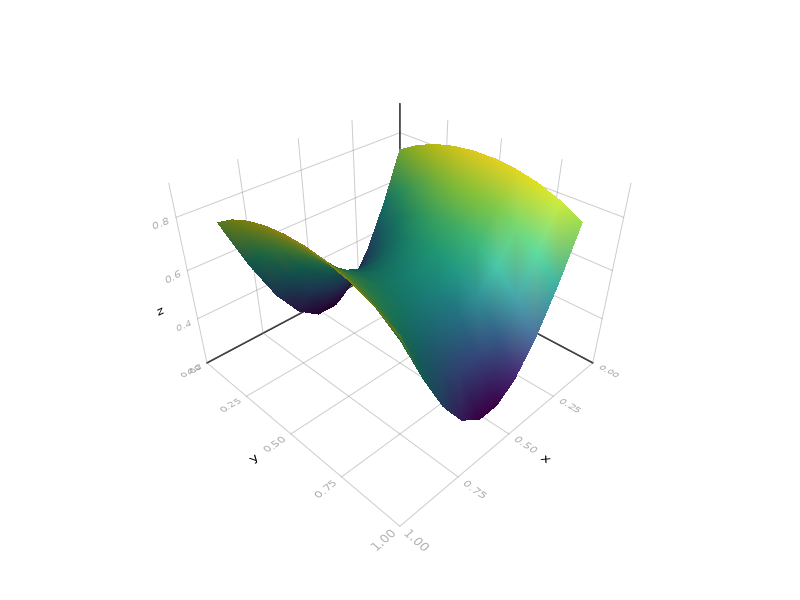

In [9]:
n = 10
y = big_rhs(n,(x,y)->1 - sin(pi*x))
A = big_matrix(n)
x = solve(A,y)
membrane = reshape(x,n,n)
partition = 1/(n+1) : 1/(n+1) : 1-1/(n+1)
using CairoMakie
surface(partition,partition,membrane)

Try changing the value of $n$ for a larger one. The shape should look smoother and more realistic for large $n$. But the computation will also take longer. Eventually it will be too long and you would not want to wait for it. If we want to solve an equation like this with a very fine mesh, we should rethink how we solve the linear system.